# Turning Tweets into Knowledge: An Introduction to Text Analytics

This data is provided courtesy of Twitter, and appropriate use of the data includes the following:

- The dataset tweets.csv is for use in this course only, and you may not redistribute or reuse this data for any purpose unrelated to this course.
- You may not extract personal information from the data or use it to identify individuals.
- You may not publically display any data in tweets.csv, or distribute tweets.csv to any third parties not participating in this course.
- At the conclusion of this course, you must permanently delete tweets.csv from your computer.

To handle the locale problem:

In [1]:
Sys.setlocale("LC_ALL", "C")

[1] "LC_CTYPE=C;LC_NUMERIC=C;LC_TIME=C;LC_COLLATE=C;LC_MONETARY=C;LC_MESSAGES=en_US.UTF-8;LC_PAPER=ko_KR.UTF-8;LC_NAME=C;LC_ADDRESS=C;LC_TELEPHONE=C;LC_MEASUREMENT=ko_KR.UTF-8;LC_IDENTIFICATION=C"

## Pre-Processing in R

In [2]:
tweets = read.csv("./dataset/tweets.csv", stringsAsFactors=FALSE)

Warning message in file(file, "rt"):
"cannot open file './dataset/tweets.csv': No such file or directory"


ERROR: Error in file(file, "rt"): cannot open the connection


In [3]:
str(tweets)

'data.frame':	1181 obs. of  2 variables:
 $ Tweet: chr  "I have to say, Apple has by far the best customer care service I have ever received! @Apple @AppStore" "iOS 7 is so fricking smooth & beautiful!! #ThanxApple @Apple" "LOVE U @APPLE" "Thank you @apple, loving my new iPhone 5S!!!!!  #apple #iphone5S pic.twitter.com/XmHJCU4pcb" ...
 $ Avg  : num  2 2 1.8 1.8 1.8 1.8 1.8 1.6 1.6 1.6 ...


In [4]:
tweets$Negative = as.factor(tweets$Avg <= -1)

In [5]:
table(tweets$Negative)


FALSE  TRUE 
  999   182 

Requires to install ```tm``` packages
```R
install.packages("tm")
install.packages("SnowballC")
```

In [6]:
library("tm")
library("SnowballC")

Loading required package: NLP



In [12]:
corpus = VCorpus(VectorSource(tweets$Tweet))
corpus

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 1181

In [13]:
corpus[[1]]$content

[1] "I have to say, Apple has by far the best customer care service I have ever received! @Apple @AppStore"

To lower the corpus,

In [14]:
corpus = tm_map(corpus, content_transformer(tolower))

In [15]:
corpus[[1]]$content

[1] "i have to say, apple has by far the best customer care service i have ever received! @apple @appstore"

To remove any Puctuation,

In [16]:
corpus = tm_map(corpus, removePunctuation)
corpus[[1]]$content

[1] "i have to say apple has by far the best customer care service i have ever received apple appstore"

In [17]:
stopwords("english")[1:10]

[1] "i"         "me"        "my"        "myself"    "we"        "our"      
 [7] "ours"      "ourselves" "you"       "your"

In [18]:
corpus = tm_map(corpus, removeWords, c("apple", stopwords("english")))
corpus[[1]]$content

[1] "   say    far  best customer care service   ever received  appstore"

Stem the Document

In [19]:
corpus = tm_map(corpus, stemDocument)
corpus[[1]]$content

[1] "say far best custom care servic ever receiv appstor"

## Bag of Words in R

In [20]:
frequencies = DocumentTermMatrix(corpus)
frequencies

<<DocumentTermMatrix (documents: 1181, terms: 3289)>>
Non-/sparse entries: 8980/3875329
Sparsity           : 100%
Maximal term length: 115
Weighting          : term frequency (tf)

In [21]:
inspect(frequencies[1000:1005, 505:515])

<<DocumentTermMatrix (documents: 6, terms: 11)>>
Non-/sparse entries: 1/65
Sparsity           : 98%
Maximal term length: 9
Weighting          : term frequency (tf)
Sample             :
      Terms
Docs   cheapen cheaper check cheep cheer cheerio cherylcol chief chiiiiqu child
  1000       0       0     0     0     0       0         0     0        0     0
  1001       0       0     0     0     0       0         0     0        0     0
  1002       0       0     0     0     0       0         0     0        0     0
  1003       0       0     0     0     0       0         0     0        0     0
  1004       0       0     0     0     0       0         0     0        0     0
  1005       0       0     0     0     1       0         0     0        0     0


In [22]:
findFreqTerms(frequencies, lowfreq=20)

[1] "android"              "anyon"                "app"                 
 [4] "appl"                 "back"                 "batteri"             
 [7] "better"               "buy"                  "can"                 
[10] "cant"                 "come"                 "dont"                
[13] "fingerprint"          "freak"                "get"                 
[16] "googl"                "ios7"                 "ipad"                
[19] "iphon"                "iphone5"              "iphone5c"            
[22] "ipod"                 "ipodplayerpromo"      "itun"                
[25] "just"                 "like"                 "lol"                 
[28] "look"                 "love"                 "make"                
[31] "market"               "microsoft"            "need"                
[34] "new"                  "now"                  "one"                 
[37] "phone"                "pleas"                "promo"               
[40] "promoipodplayerpromo" "realli"               "releas"              
[43] "samsung"              "say"                  "store"               
[46] "thank"                "think"                "time"                
[49] "twitter"              "updat"                "use"                 
[52] "via"                  "want"                 "well"                
[55] "will"                 "work"

In [23]:
sparse = removeSparseTerms(frequencies, 0.995)
sparse

<<DocumentTermMatrix (documents: 1181, terms: 309)>>
Non-/sparse entries: 4669/360260
Sparsity           : 99%
Maximal term length: 20
Weighting          : term frequency (tf)

In [24]:
tweetsSparse = as.data.frame(as.matrix(sparse))

In [25]:
colnames(tweetsSparse) = make.names(colnames(tweetsSparse))

In [26]:
tweetsSparse$Negative = tweets$Negative

In [27]:
library("caTools")

In [28]:
set.seed(123)

In [29]:
split = sample.split(tweetsSparse$Negative, SplitRatio=0.7)
trainSparse = subset(tweetsSparse, split == TRUE)
testSparse = subset(tweetsSparse, split == FALSE)

### Quick Question

In [30]:
findFreqTerms(frequencies, lowfreq = 100)

[1] "iphon" "itun"  "new"

## Predicting Sentiment

### CART

In [31]:
library("rpart")
library("rpart.plot")

In [32]:
tweetCART = rpart(Negative ~ ., data=trainSparse, method="class")

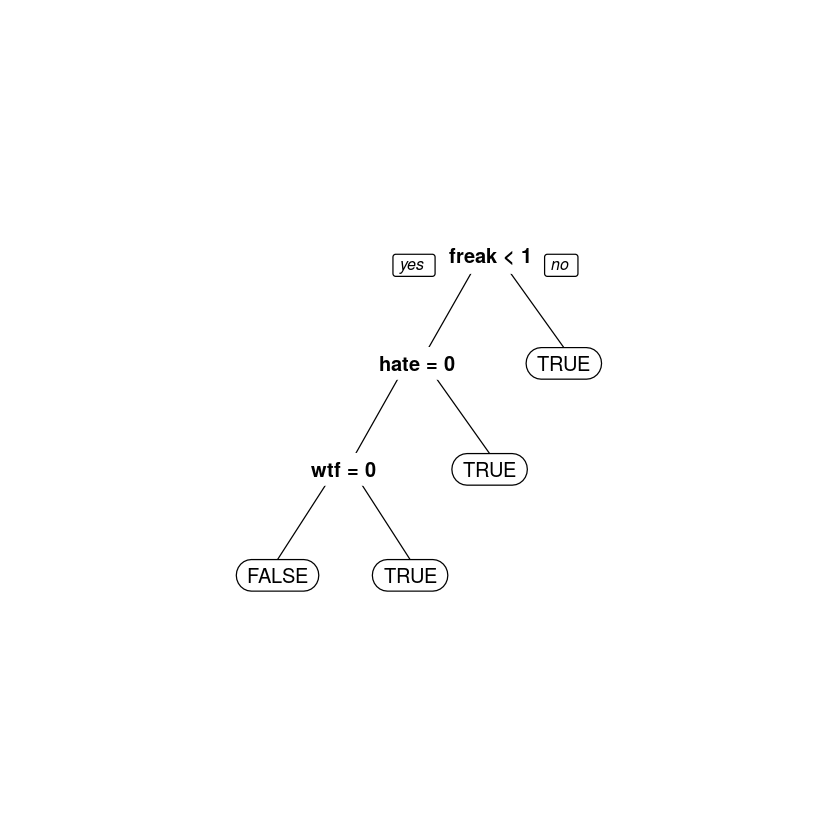

In [33]:
prp(tweetCART)

In [34]:
predictCART = predict(tweetCART, newdata=testSparse, type="class")
table(testSparse$Negative, predictCART)

       predictCART
        FALSE TRUE
  FALSE   294    6
  TRUE     37   18

In [36]:
accuracy = (294 + 18) / nrow(testSparse)
accuracy

[1] 0.8788732

In [37]:
table(testSparse$Negative)


FALSE  TRUE 
  300    55 

In [38]:
baseline_acc = 300 / 355
baseline_acc

[1] 0.8450704

### Random Forest

In [40]:
library("randomForest")
set.seed(123)

In [41]:
tweetRF = randomForest(Negative ~ ., data=trainSparse)

In [42]:
predictRF = predict(tweetRF, newdata=testSparse)
table(testSparse$Negative, predictRF)

       predictRF
        FALSE TRUE
  FALSE   293    7
  TRUE     34   21

In [43]:
rf_accuracy = (293 + 21) / nrow(testSparse)
rf_accuracy

[1] 0.884507

### Quick Question : Logistic Regression

In [48]:
tweetLog = glm(Negative ~ ., data=trainSparse, family='binomial')

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


In [49]:
predictLog = predict(tweetLog, newdata=testSparse, type='response')

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


In [50]:
table(testSparse$Negative, predictLog > 0.5)

       
        FALSE TRUE
  FALSE   254   46
  TRUE     25   30

In [51]:
log_accuracy = (254 + 30) / nrow(testSparse)
log_accuracy

[1] 0.8

If you were to compute the accuracy on the training set instead, you would see that the model does really well on the training set - this is an example of over-fitting. The model fits the training set really well, but does not perform well on the test set. A logistic regression model with a large number of variables is particularly at risk for overfitting.

Note that you might have gotten a different answer than us, because the glm function struggles with this many variables. The warning messages that you might have seen in this problem have to do with the number of variables, and the fact that the model is overfitting to the training set.